# Classification - Multi-Layer neural network Case(For Mnist)

# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

#MNIST 데이터
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: cpu


# Hyper parameter setting

In [2]:
# hypter parameter setting
learning_rate = 1e-1
epochs = 25
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
# batch_size 8, 16, 32, 64 식으로
act = nn.ReLU()
h = 200
display_step = 5

# Load data and pre-process data 

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


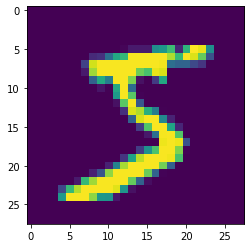

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([0, 6, 4, 1, 4, 3, 8, 7, 1, 9, 0, 4, 5, 6, 9, 9, 0, 8, 6, 8, 8, 8, 7, 8,
        8, 7, 0, 8, 0, 6, 7, 1])


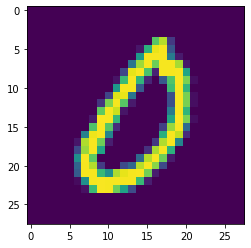

In [3]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Multi Layer Logistic Regression

## Train and result (with mini-batch stochastic gradient descent)

In [4]:
# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),h),
        act,
        nn.Linear(h,10),
        )

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1) #32x784
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
        #loss.cpu().detach().numpy(): plot그리기 위해서 numpy로 변환
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

Epoch: 1 \Loss: tensor(0.2170, grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0930, grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0036, grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0015, grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0050, grad_fn=<NllLossBackward>)


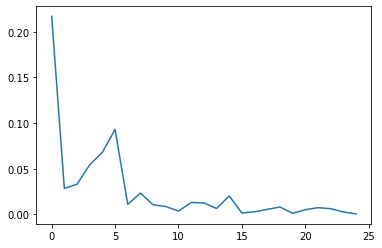

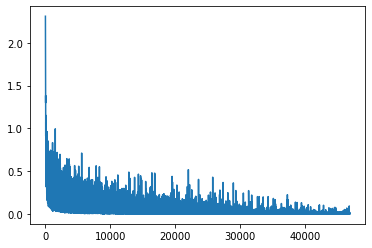

In [5]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

In [6]:
# test
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9816.)
accuracy tensor(0.9816)


In [7]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 969,    1,    1,    0,    1,    0,    3,    0,    2,    3],
       [   0, 1124,    2,    2,    0,    0,    2,    1,    4,    0],
       [   3,    2, 1010,    1,    3,    0,    2,    6,    5,    0],
       [   0,    0,    3,  991,    0,    6,    0,    2,    3,    5],
       [   1,    0,    1,    1,  966,    0,    3,    3,    0,    7],
       [   2,    0,    0,    5,    0,  878,    3,    1,    2,    1],
       [   4,    2,    3,    1,    4,    2,  940,    0,    2,    0],
       [   1,    4,    8,    2,    1,    0,    0, 1006,    3,    3],
       [   3,    0,    2,    2,    4,    0,    3,    4,  953,    3],
       [   1,    3,    0,    2,   10,    3,    1,    4,    6,  979]])

## Advanced: Weight initialization

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),h),
        act,
        nn.Linear(h,10),
        )

model.apply(init_weights)
model = model.to(device)
model.train()


# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % 5 == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

<ipython-input-8-22434cebd5b0>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch: 1 \Loss: tensor(0.0888, grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0292, grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0091, grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0033, grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0022, grad_fn=<NllLossBackward>)


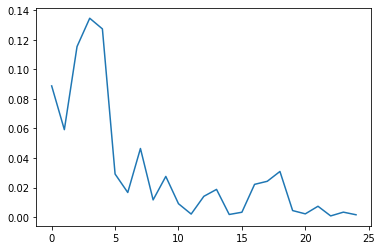

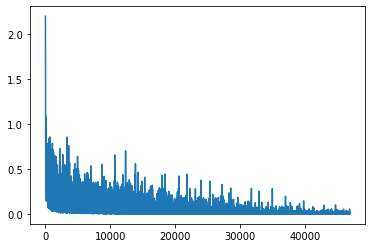

In [9]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

In [10]:
# test
model.eval()
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 10000, shuffle = True, num_workers = 1, drop_last = True)
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9826.)
accuracy tensor(0.9826)


In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

prediction : (10000,)
true label : (10000,)


array([[ 971,    1,    1,    1,    2,    0,    1,    1,    1,    1],
       [   0, 1124,    3,    2,    0,    1,    2,    1,    2,    0],
       [   5,    2, 1009,    4,    5,    0,    1,    3,    3,    0],
       [   0,    0,    3,  991,    0,    4,    0,    1,    3,    8],
       [   0,    0,    2,    2,  968,    0,    4,    1,    0,    5],
       [   2,    0,    0,    5,    1,  876,    3,    0,    3,    2],
       [   3,    2,    0,    1,    5,    4,  943,    0,    0,    0],
       [   0,    5,    8,    3,    0,    0,    0, 1004,    2,    6],
       [   7,    0,    1,    6,    4,    2,    2,    3,  945,    4],
       [   3,    2,    0,    4,   10,    3,    0,    3,    1,  983]],
      dtype=int64)